<a href="https://colab.research.google.com/github/ynusinovich/streamflow-prediction/blob/main/YAN/Training_and_Evaluation_DARTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4249de19-7714-ae64-a7c9-c68ffe66e85e)


In [ ]:
!python --version

Python 3.7.14


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# https://www.youtube.com/watch?v=GNvtg2R4Uew
# https://unit8co.github.io/darts/

# https://unit8co.github.io/darts/examples/01-multi-time-series-and-covariates.html
# https://unit8co.github.io/darts/examples/08-DeepAR-examples.html
# https://unit8co.github.io/darts/examples/15-static-covariates.html
# https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844
# https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7
# https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594

# https://unit8co.github.io/darts/examples/04-RNN-examples.html ?

In [ ]:
!pip install darts==0.21.0
!pip install pyyaml==5.4.1
!pip install -U matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.21.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import darts
print(darts.__version__)

0.21.0


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values

from darts.utils.likelihood_models import QuantileRegression

from sklearn.metrics import mean_absolute_error

In [ ]:
# Data Loading and Splitting

In [ ]:
datapath = "/content/gdrive/MyDrive/Work Shared/AISC/2022-06-16 Streamflow Prediction/HYSETS_combined_and_cleaned_data.csv"
df = pd.read_csv(datapath, index_col = 0)
df

,watershedID,drainage_area,elevation,slope,discharge,pr,tasmax,tasmin,centroid_lat,centroid_lon,...,Land_Use_Wetland_frac,Land_Use_Water_frac,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Permeability_logk_m2,Porosity_frac,Hydrometric_station_latitude,Hydrometric_station_longitude
time,,,,,,,,,,,,,,,,,,,,,
1978-01-01,859.0,440.833477,1367.754077,8.435179,0.000,0.000000,-5.432079,-27.493258,49.97735,-113.6860,...,0.0106,0.0001,0.0144,0.0852,0.0447,0.0,-15.200000,0.19000,49.97735,-113.6860
1978-01-02,859.0,440.833477,1367.754077,8.435179,0.000,0.000000,-3.328034,-23.670760,49.97735,-113.6860,...,0.0106,0.0001,0.0144,0.0852,0.0447,0.0,-15.200000,0.19000,49.97735,-113.6860
1978-01-03,859.0,440.833477,1367.754077,8.435179,0.000,10.101207,-12.074663,-22.485310,49.97735,-113.6860,...,0.0106,0.0001,0.0144,0.0852,0.0447,0.0,-15.200000,0.19000,49.97735,-113.6860
1978-01-04,859.0,440.833477,1367.754077,8.435179,0.000,6.966643,-17.925337,-19.597303,49.97735,-113.6860,...,0.0106,0.0001,0.0144,0.0852,0.0447,0.0,-15.200000,0.19000,49.97735,-113.6860
1978-01-05,859.0,440.833477,1367.754077,8.435179,0.000,0.051100,-11.183038,-21.545280,49.97735,-113.6860,...,0.0106,0.0001,0.0144,0.0852,0.0447,0.0,-15.200000,0.19000,49.97735,-113.6860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,2370.0,497.006132,888.509557,1.735527,0.001,0.000000,-15.509319,-31.992678,49.30725,-107.7037,...,0.0086,0.0016,0.0126,0.0038,0.2816,0.0,-15.678715,0.15407,49.30725,-107.7037
2009-12-28,2370.0,497.006132,888.509557,1.735527,0.001,0.000000,-13.991346,-27.980030,49.30725,-107.7037,...,0.0086,0.0016,0.0126,0.0038,0.2816,0.0,-15.678715,0.15407,49.30725,-107.7037
2009-12-29,2370.0,497.006132,888.509557,1.735527,0.001,0.000000,-13.986687,-26.996006,49.30725,-107.7037,...,0.0086,0.0016,0.0126,0.0038,0.2816,0.0,-15.678715,0.15407,49.30725,-107.7037


In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
df_train = df[:'2000-01-01']
df_test = df['2000-01-01':]
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
df.reset_index(inplace=True)
df_cov = df[["time", "watershedID", "pr", "tasmax", "tasmin"]]
cov_series = TimeSeries.from_group_dataframe(
             df_cov, time_col = "time", group_cols = ["watershedID"], fill_missing_dates = True, freq = 'D'
             )

In [ ]:
static_cols = ["drainage_area", "elevation", "slope", "centroid_lat",
               "centroid_lon", "Gravelius", "Perimeter",
               "Aspect_deg", "Land_Use_Forest_frac", "Land_Use_Grass_frac", "Land_Use_Wetland_frac",
               "Land_Use_Water_frac", "Land_Use_Urban_frac", "Land_Use_Shrubs_frac",
               "Land_Use_Crops_frac", "Land_Use_Snow_Ice_frac", "Permeability_logk_m2", "Porosity_frac",
               "Hydrometric_station_latitude", "Hydrometric_station_longitude"]

train_series = TimeSeries.from_group_dataframe(
             df_train.drop(columns = ["pr", "tasmax", "tasmin"]), time_col = "time", group_cols = ["watershedID"], fill_missing_dates = True, freq = 'D', static_cols = static_cols
             )

test_series = TimeSeries.from_group_dataframe(
             df_test.drop(columns = ["pr", "tasmax", "tasmin"]), time_col = "time", group_cols = ["watershedID"], fill_missing_dates = True, freq = 'D', static_cols = static_cols
             )

In [ ]:
# Model Training

In [ ]:
# model = RNNModel(
#     model="LSTM",
#     input_chunk_length=365*5,
#     training_length=365*5 + 180,
#     hidden_dim=256,
#     n_rnn_layers=2,
#     dropout=0.15,
#     n_epochs=4,
#     pl_trainer_kwargs={
#                      "accelerator": "gpu",
#                      "gpus": [0]}
# )

# model.fit(train_series, future_covariates=cov_series, verbose=True) 


In [ ]:
# model.save("/content/gdrive/MyDrive/Work Shared/AISC/2022-06-16 Streamflow Prediction/darts_rnnmodel_version_2.pt")

In [ ]:
# EPOCHS = 5
# INLEN = 365*5
# HIDDEN = 128
# LSTMLAYERS = 2
# ATTHEADS = 4
# DROPOUT = 0.15
# BATCH = 32

# N_FC = 365          # default forecast horizon
# N_SAMPLES = 30      # number of times a prediction is sampled from a probabilistic model
# N_JOBS = -1         # parallel processors to use;  -1 = all processors

# # default quantiles for QuantileRegression
# QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]



# model = TFTModel(input_chunk_length=INLEN,
#                  output_chunk_length=N_FC,
#                  hidden_size=HIDDEN,
#                  lstm_layers=LSTMLAYERS,
#                  num_attention_heads=ATTHEADS,
#                  dropout=DROPOUT,
#                  batch_size=BATCH,
#                  n_epochs=EPOCHS,
#                  likelihood=QuantileRegression(quantiles=QUANTILES),
#                  force_reset=True,
#                  pl_trainer_kwargs={
#                      "accelerator": "gpu",
#                      "gpus": [0]
#                  })                
                    
# model.fit(train_series, future_covariates=cov_series, verbose=True)  

In [ ]:
# model.save("/content/gdrive/MyDrive/Work Shared/AISC/2022-06-16 Streamflow Prediction/darts_tftmodel_version_2.pt")

In [ ]:
# Model Evaluation

In [ ]:
def smape(A, F):
    A = A.astype('float64')
    F = F.astype('float64')
    for i in range(len(A)):
      if A[i] == F[i]:
        A[i] = 0.000001
        F[i] = 0.000001
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python

In [ ]:
model_names = ["darts_rnnmodel_version_2.pt", "darts_tftmodel_version_2.pt"]

In [ ]:
smape_average_list = []

for model_name in model_names:
  if "rnnmodel" in model_name:
    model_loaded = RNNModel.load(f"/content/gdrive/MyDrive/Work Shared/AISC/2022-06-16 Streamflow Prediction/{model_name}")
  if "tftmodel" in model_name:
    model_loaded = TFTModel.load(f"/content/gdrive/MyDrive/Work Shared/AISC/2022-06-16 Streamflow Prediction/{model_name}")
  smape_list = []
  for watershed in range(len(train_series)):
    timestamps = 3286
    predictions = model_loaded.predict(n=timestamps, series=train_series[watershed], future_covariates=cov_series[watershed], verbose = False).values()
    predictions = np.array([val[0] if val[0] >= 0 else 0 for val in predictions])
    actual = test_series[watershed][:timestamps].values()
    actual = np.array([val[0] for val in actual])
    smape_val = smape(actual, predictions)
    smape_list.append(smape_val)
  smape_average = sum(smape_list)/len(smape_list)
  smape_average_list.append(smape_average)
smape_average_list

# 159.59634175121755 for TFT
# 165.75605357594338 for RNN
# 149.82650097373372 for tuned RNN with smaller dataset
# 123.23225149396586 for tuned TFT with smaller dataset

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_D

[149.82650097373372, 123.23225149396586]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


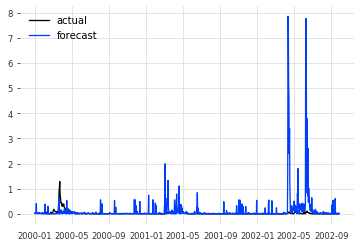

In [ ]:
watershed = 10
timestamps = 1000 #3286
pred = model_loaded.predict(n=timestamps, series=train_series[watershed], future_covariates=cov_series[watershed])

pred = pd.DataFrame(index = pred.time_index, data = [pred_val[0] if pred_val[0] >=0 else 0 for pred_val in pred.values()])
# test_series[watershed][:timestamps].plot(label="actual")
# pred.plot(label = "forecast")
plt.plot(test_series[watershed][:timestamps].time_index, test_series[watershed][:timestamps].values(), label = "actual")
plt.plot(pred.index, pred.loc[:,0], label="forecast")

plt.legend()
plt.show();